In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy import mean

In [2]:
def read_file(filename , samples = 1024 ):
    data = np.fromfile(filename,  dtype=np.int16)
    n = len(data)/samples
    data = np.array(np.array_split(np.array(data),n))
    return data

dataLED=read_file(filename= '/data/abalone/2021_11_19_T1440_ABALONE_0kV_SiPM2_32V_thr100.dat' , samples = 1024)

In [11]:
n=len(dataLED)
print("Il numero degli eventi è ", n)

nn=len(dataLED[0]) #nn=1024 è il numero di campioni ognuno preso in un intervallo di 10ns
print('Il numero di campioni è', nn, 'ognuno preso in un intervallo di 10ns')

inf=int(nn/2)-10  #limite inferiore dell'intervallo in cui voglio cercare il max
sup=int(nn/2)+60  #limite superiore dell'intervallo in cui voglio cercare il max
print("L'intervallo in cui cerco il max è [", inf, ",", sup,"]" )

Il numero degli eventi è  519211
Il numero di campioni è 1024 ognuno preso in un intervallo di 10ns
L'intervallo in cui cerco il max è [ 412 , 1112 ]


In [12]:
BASE, MAX_POS , MAX, INF, SUP, A, B, AREA, TAU, ENT = [], [], [], [], [], [], [], [], [], []

for i in range(n):
    wf=(dataLED[i])*(-1)
    
    max_pos=inf+np.where(wf[inf:sup]==np.max(wf[inf:sup]))[0][0]  #cerco il max nell'intervallo [inf,sup] definito all'inizio
    
    p=max_pos-20
    bl=np.mean(dataLED[i][p-40:p]) #definizione della baseline come media su 40 campioni poco prima del picco selezionato
    std=np.std(dataLED[i][p-40:p]) #definizione della deviazione standard su 40 campioni poco prima del picco selezionato
    
    wf=(dataLED[i]-bl)*(-1)
    
    maxx=wf[max_pos]   #valore della wf nel massimo
    
    #definizione estremi di integrazione
    try:
        if wf[max_pos]>3*std :
            idx1= np.where(wf[0:max_pos]<3*std)[0][-1]
            
        else:
            idx1= np.where(wf[0:max_pos]<0)[0][-1]
                        
    except:
        print("Per wf_",i,"non è possibile determinare l'estremo a dell'integrale")
           
    if wf[max_pos]>3*std :
        try:
            idx2= max_pos+np.where(wf[max_pos:nn]<3*std)[0][0]
            
        except:
            print(f"Per wf_{i} non è possibile determinare l'estremo b dell'integrale")
    else:
        try:
            idx2= max_pos+np.where(wf[max_pos:nn]<0)[0][0]
            
        except:
            print(f"Per wf_{i} non è possibile determinare l'estremo b dell'integrale")
        
    a=idx1-2
    b=idx2+2
        
    area=np.sum(wf[a:b]) #calcolo integrale
    
    #definizione entropia
    if np.sum(wf) > 1:
            norm = np.abs(wf[wf!=0]/np.sum(wf))
            entropy = -np.sum(norm*np.log10(norm))
    else: entropy = 0

    #definizione di tau
    try:
            tt10 = np.where(wf[max_pos:]<maxx*0.1)[0][0] + max_pos
            tt90 = np.where(wf[max_pos:]<maxx*0.9)[0][0] + max_pos
            tau = tt10 - tt90
    except:
            tau = 0
            
    BASE.append(bl)
    MAX_POS.append(max_pos)    
    MAX.append(maxx)
    INF.append(inf)
    SUP.append(sup)
    A.append(a)
    B.append(b)
    AREA.append(area)
    TAU.append(tau)
    ENT.append(entropy)
    
#creazione dataframe    
data = pd.DataFrame(columns=['pos_max','wf_max', 'inf', 'sup', 'a','b','area', 'tau', 'entropy'])
data['inf'] = INF
data['sup'] = SUP
data['wf_max'] =  MAX
data['pos_max'] = MAX_POS
data['a'] = A
data['b'] = B
data['area'] = AREA
data['tau']=TAU
data['entropy']=ENT

data.to_hdf(f'data_ABALONE_.h5', key='df', mode='w')

Per wf_42290 non è possibile determinare l'estremo b dell'integrale
Per wf_75984 non è possibile determinare l'estremo b dell'integrale
Per wf_111305 non è possibile determinare l'estremo b dell'integrale
Per wf_267278 non è possibile determinare l'estremo b dell'integrale
Per wf_323194 non è possibile determinare l'estremo b dell'integrale
Per wf_352900 non è possibile determinare l'estremo b dell'integrale
Per wf_471206 non è possibile determinare l'estremo b dell'integrale
Per wf_481562 non è possibile determinare l'estremo b dell'integrale
Per wf_489338 non è possibile determinare l'estremo b dell'integrale


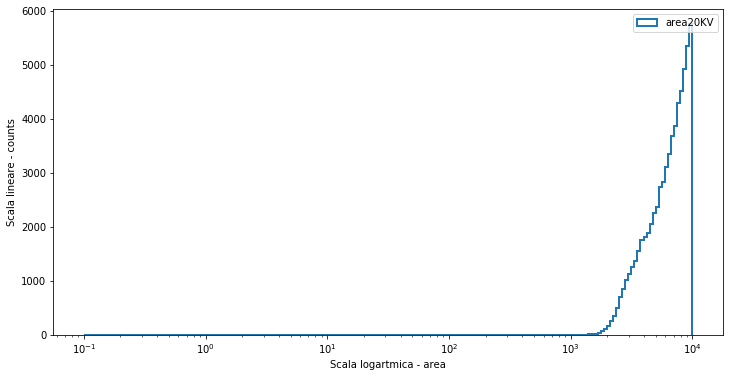

In [13]:
#istogramma area

area_space = np.logspace(-1,4,200)  #partendo da 10^(-1) fino a 10^4 con 200bins
plt.figure(figsize=(12,6))
plt.hist(data['area'],bins=area_space,histtype='step',lw=2,density=False, label='area20KV')

plt.ylabel('Scala lineare - counts')
plt.xlabel('Scala logartmica - area')

plt.xscale('log')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

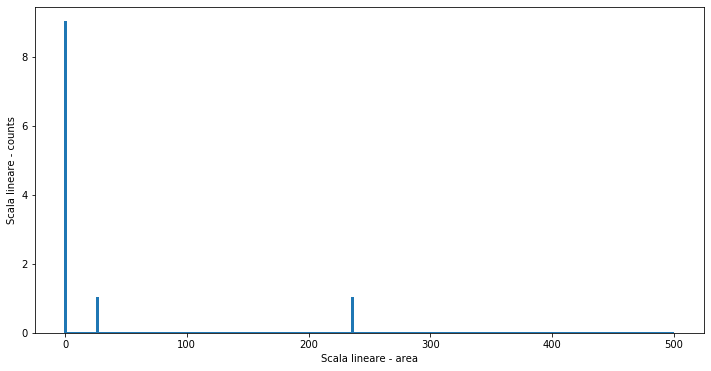

In [14]:
area_space = np.linspace(0,500,500)
plt.figure(figsize=(12,6))
plt.hist(data['area'],bins=area_space,histtype='step',lw=2,density=False)

plt.xlabel('Scala lineare - area')
plt.ylabel('Scala lineare - counts')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

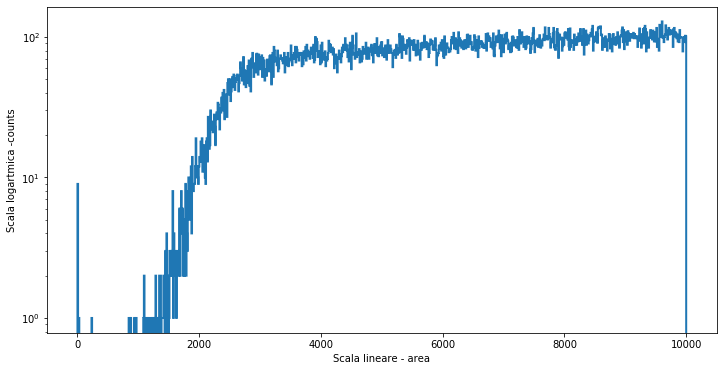

In [15]:
area_space = np.linspace(0,10000,1000)
plt.figure(figsize=(12,6))
plt.hist(data['area'],bins=area_space,histtype='step',lw=2,density=False)

plt.yscale("log")
plt.xlabel('Scala lineare - area')
plt.ylabel('Scala logartmica -counts')

plt.show

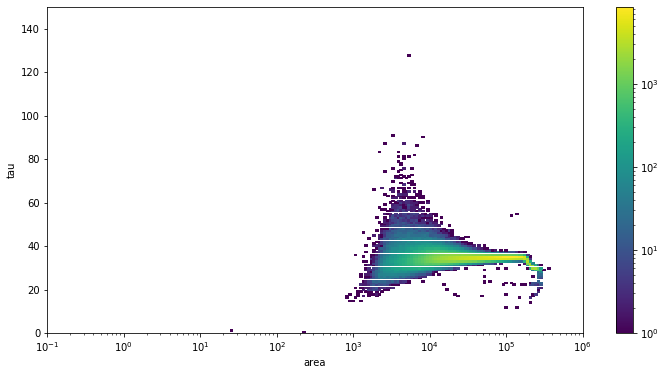

In [16]:
#grafico 2d tau-area

area_space = np.logspace(-1,6,200)
tau_space = np.linspace(0,150,200)
plt.figure(figsize=(12,6))

plt.hist2d(data['area'],data['tau'],bins=(area_space,tau_space),norm=matplotlib.colors.LogNorm())
#plt.axhline(y=70, color='red')
#plt.axhline(y=3, color='red')
plt.xscale('log')

plt.xlabel('area')
plt.ylabel('tau')

plt.colorbar()

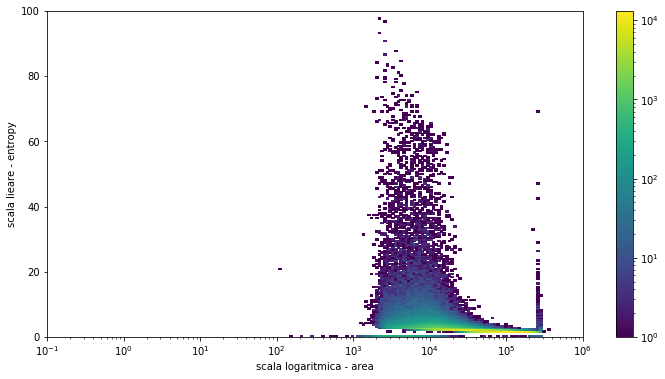

In [9]:
#grafico 2d entropia-area
area_space = np.logspace(-1,6,200)
ent_space = np.linspace(0,100,200)
plt.figure(figsize=(12,6))

plt.hist2d(data['area'],data['entropy'],bins=(area_space,ent_space),norm=matplotlib.colors.LogNorm())
plt.xscale('log')

plt.xlabel('scala logaritmica - area')
plt.ylabel('scala lieare - entropy')

plt.colorbar()

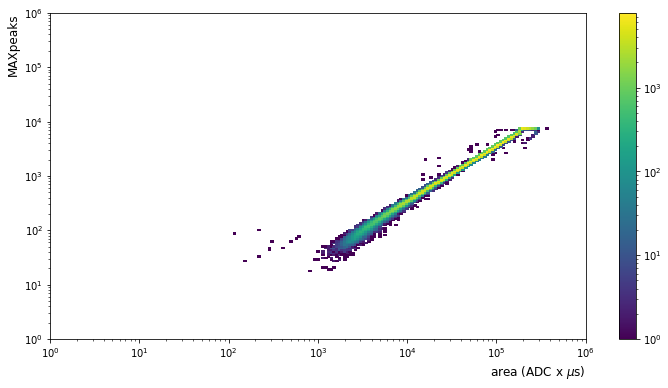

In [10]:
#grafico 2d ampiezza_max-area
area_space = np.logspace(0,6,200)
max_space = np.logspace(0,6,200)
plt.figure(figsize=(12,6))
plt.hist2d(data['area'],data['wf_max'],bins=(area_space,max_space),norm=matplotlib.colors.LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlabel('area (ADC x $\mu$s)', ha='right', x=1, fontsize=12)
plt.ylabel('MAXpeaks', ha='right', y=1, fontsize=12)
#plt.title(f'ABALONE at {volts} kV')
plt.colorbar()